In [5]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd
from pandas import datetime



df_fx_data = pd.read_csv('/home/gustavo/Documentos/temperatura2.csv',header=0, sep='\t')

df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'], format = '%Y-%m-%d')
indexed_df = df_fx_data.set_index('Date')

ts = indexed_df['Value']
ts.head(5)


/home/gustavo/miniconda3/envs/venv_hominid/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Date
2007-01-01    27.95
2007-02-01    30.63
2007-03-01    31.36
2007-04-01    27.66
2007-05-01    23.27
Name: Value, dtype: float64

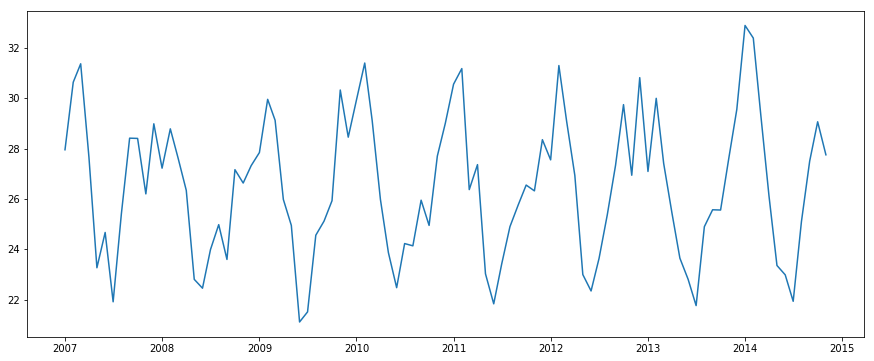

In [7]:
plt.plot(ts.index.to_pydatetime(), ts.values)

In [ ]:
#Como os dados são mensais então a transformação abaixo é apenas para seguir o nome das variáveis do Modelo

In [8]:
ts_week = ts.resample('m').mean()

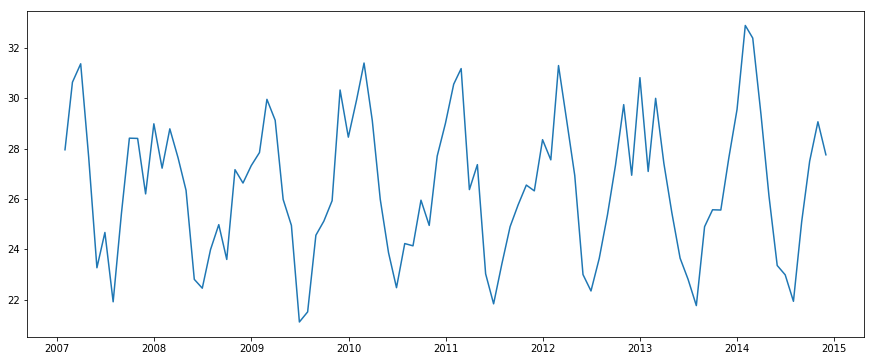

In [9]:
plt.plot(ts_week.index.to_pydatetime(), ts_week.values)

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=2,center=False).mean() 
    rolstd = timeseries.rolling(window=2,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color='blue',label='Original')
    mean = plt.plot(rolmean.index.to_pydatetime(), rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.index.to_pydatetime(), rolstd.values, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Teste de Resultados Estacionários - Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

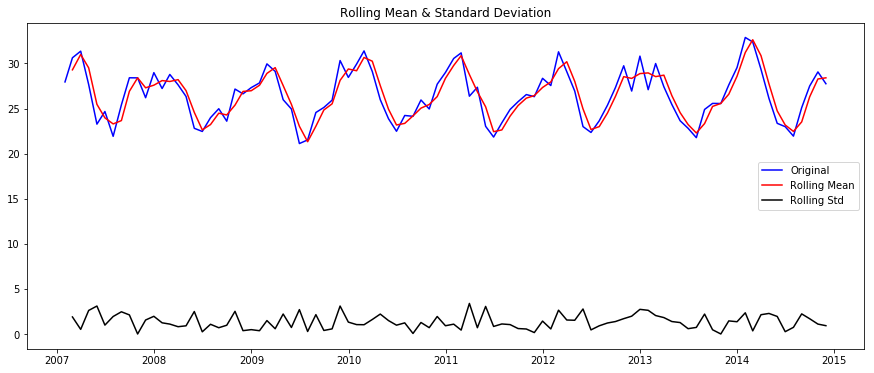

Teste de Resultados Estacionários - Dickey-Fuller test:
Test Statistic                 -3.892609
p-value                         0.002090
#Lags Used                      9.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [11]:
test_stationarity(ts_week)

In [12]:
ts_week_log = np.log(ts_week)

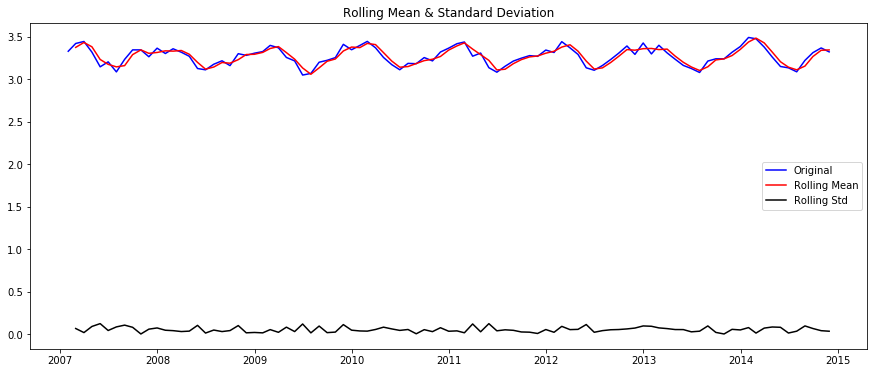

Teste de Resultados Estacionários - Dickey-Fuller test:
Test Statistic                 -4.055960
p-value                         0.001144
#Lags Used                      9.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


In [13]:
test_stationarity(ts_week_log)

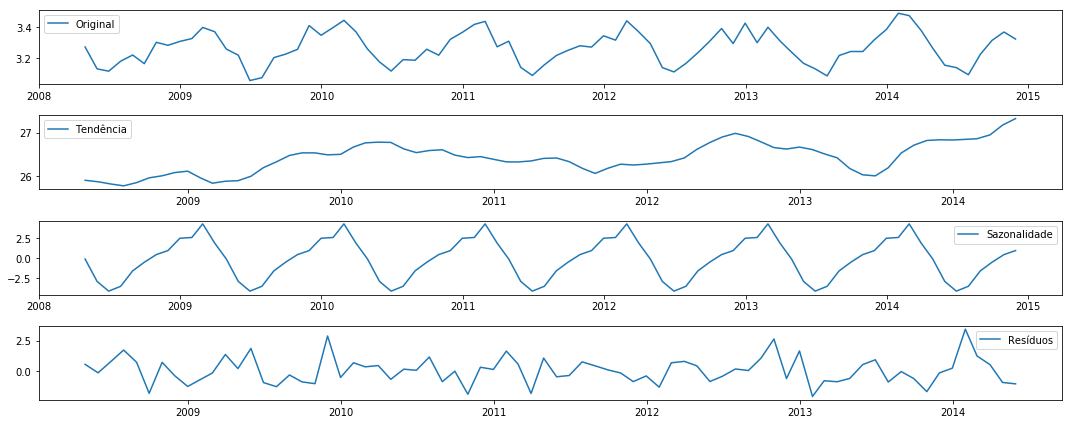

In [14]:
decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ts_week_log_select = ts_week_log[-80:]

plt.subplot(411)
plt.plot(ts_week_log_select.index.to_pydatetime(), ts_week_log_select.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_week_log_select.index.to_pydatetime(), trend[-80:].values, label='Tendência')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_week_log_select.index.to_pydatetime(), seasonal[-80:].values,label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_week_log_select.index.to_pydatetime(), residual[-80:].values, label='Resíduos')
plt.legend(loc='best')
plt.tight_layout()

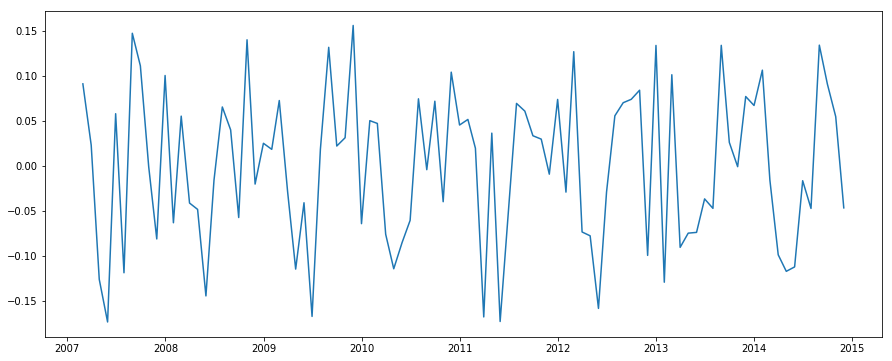

In [21]:
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff.index.to_pydatetime(), ts_week_log_diff.values)

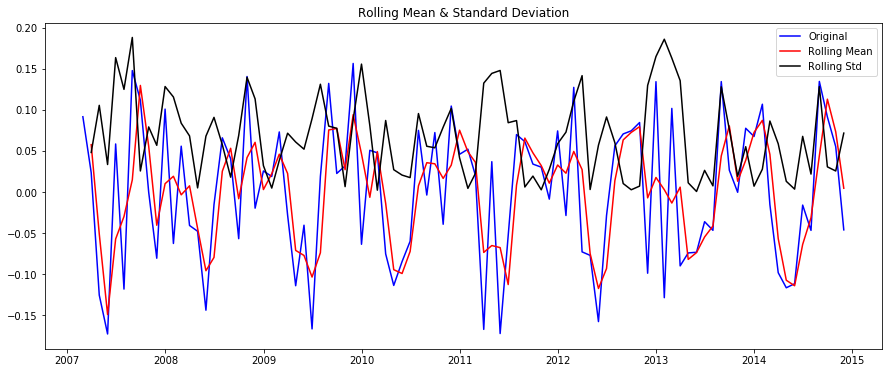

Teste de Resultados Estacionários - Dickey-Fuller test:
Test Statistic                -7.914415e+00
p-value                        3.870475e-12
#Lags Used                     1.000000e+01
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In [22]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

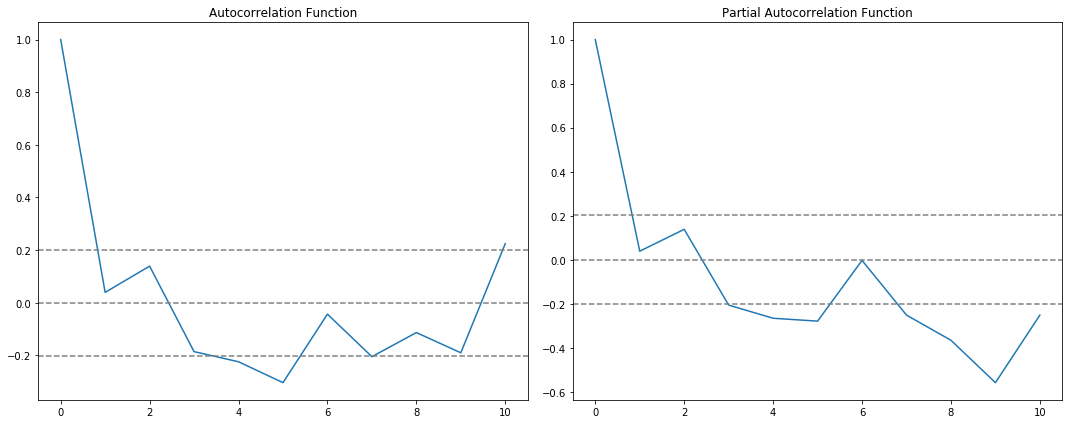

In [23]:
#ACF and PACF plots

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [37]:
model = ARIMA(ts_week_log, order=(2, 1, 0))  
results_ARIMA = model.fit(disp=-1) 

Text(0.5,1,'RSS: 0.6711')

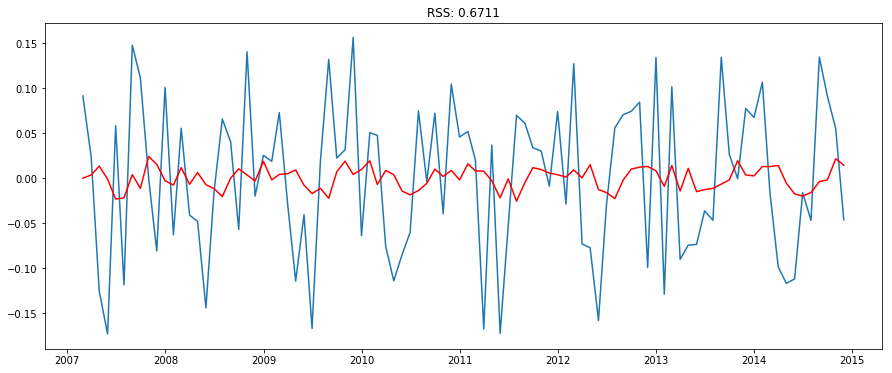

In [39]:
model = ARIMA(ts_week_log, order=(2, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff.index.to_pydatetime(), ts_week_log_diff.values)
plt.plot(ts_week_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   94
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  98.895
Method:                       css-mle   S.D. of innovations              0.084
Date:                Tue, 28 Nov 2017   AIC                           -189.791
Time:                        18:54:06   BIC                           -179.618
Sample:                    02-28-2007   HQIC                          -185.681
                         - 11-30-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.010      0.015      0.988      -0.020       0.021
ar.L1.D.Value     0.0339      0.102      0.332      0.741      -0.166       0.234
ar.L2.D.Value     0.1376      0.102     

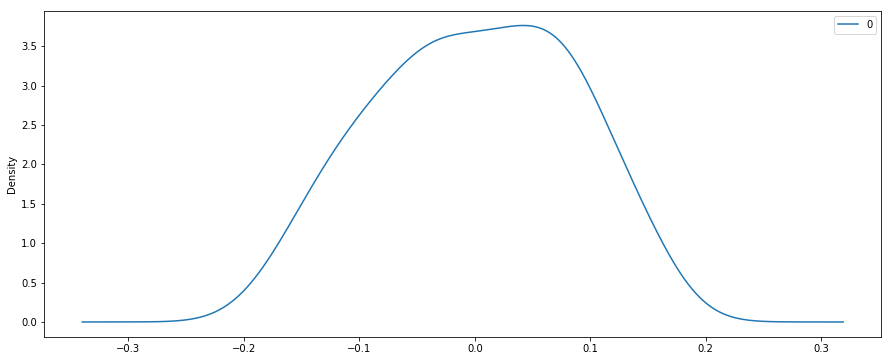

In [26]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2007-02-28    0.000161
2007-03-31    0.003759
2007-04-30    0.013529
2007-05-31   -0.000888
2007-06-30   -0.023003
Freq: M, dtype: float64


In [28]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

Text(0.5,1,'RMSE: 2.9541')

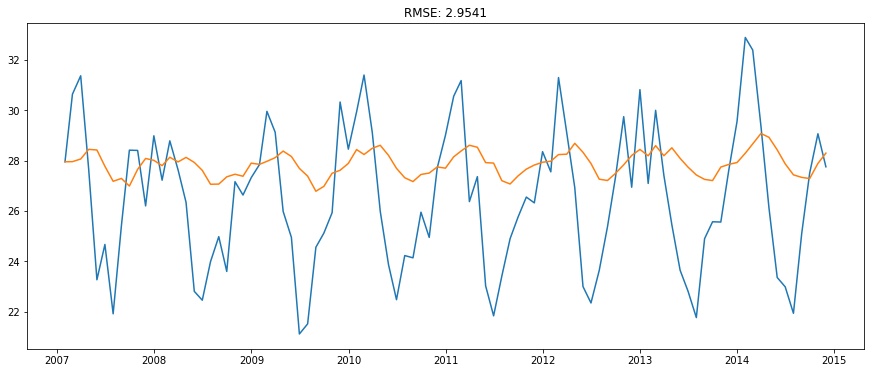

In [29]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week.index.to_pydatetime(), ts_week.values)
plt.plot(ts_week.index.to_pydatetime(), predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)))

In [40]:
size = int(len(ts_week_log) - 15)
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(3,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

predictions_series = pd.Series(predictions, index = test.index)

Printing Predicted vs Expected Values...


predicted=25.085185, expected=25.570000
predicted=27.207931, expected=25.560000
predicted=26.180443, expected=27.620000
predicted=28.784795, expected=29.550000
predicted=31.348591, expected=32.880000
predicted=35.444075, expected=32.380000
predicted=34.444716, expected=29.350000
predicted=28.803162, expected=26.120000
predicted=24.183743, expected=23.360000
predicted=21.001215, expected=22.990000
predicted=21.219429, expected=21.940000
predicted=20.891341, expected=25.100000
predicted=25.468795, expected=27.500000
predicted=30.131299, expected=29.060000
predicted=31.194399, expected=27.750000


Printing Mean Squared Error of Predictions...
Test MSE: 0.007902


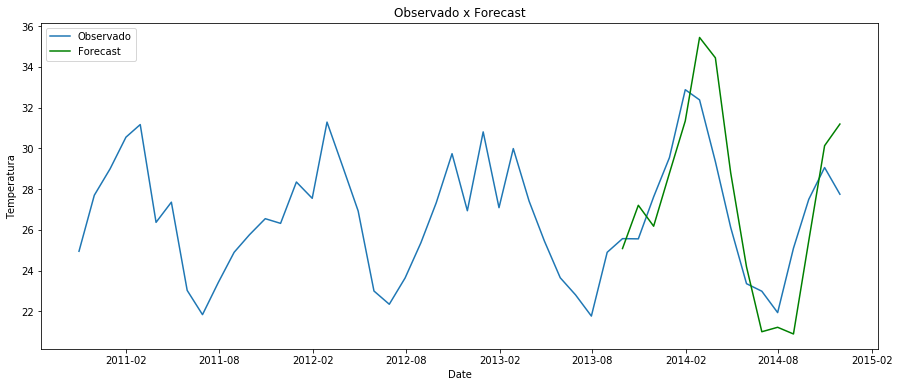

In [50]:
fig, ax = plt.subplots()
ax.set(title='Observado x Forecast', xlabel='Date', ylabel='Temperatura')
ax.plot(ts_week[-50:], '', label='Observado')
ax.plot(np.exp(predictions_series), 'g', label='Forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')